In [24]:
import sys
sys.path.append('../..')

import numpy as np
import pandas as pd
import copy
from matplotlib import pyplot as plt
from matplotlib import rc, cm, rcParams
rc('text', usetex=True)
rc('font', family='serif')
rcParams.update({'font.size': 18})

from scipy.stats import linregress
from scipy.optimize import lsq_linear, curve_fit

#import pickle

from analosis.utilities.useful_functions import Utilities, estimate_quality

In [25]:
sample = 'mithril'
path = '/Users/pierrefleury/GitHub/analosis/analosis/results'
input_kwargs = pd.read_csv(path + '/datasets/' + sample + '_sample_input_kwargs.csv')

In [88]:
# Estimate quality of golden satmple images from SNR
quality = estimate_quality(input_kwargs, snr_cut=1)

In [89]:
# Import summary results for sample

path_summary = '/Users/pierrefleury/GitHub/analosis/analosis/results/summary/'
job = 'pm'
summary_g1_kwargs = pd.read_csv(path_summary + 'summary_gamma1_' + job + '_' + sample +'.csv')
summary_g2_kwargs = pd.read_csv(path_summary + 'summary_gamma2_' + job + '_' + sample +'.csv')

in_gamma1_converged = summary_g1_kwargs['in_gamma1'].to_numpy()
out_gamma1          = summary_g1_kwargs['out_gamma1'].to_numpy()
g1_lower_error      = summary_g1_kwargs['g1_lower'].to_numpy()
g1_upper_error      = summary_g1_kwargs['g1_upper'].to_numpy()
b_g1                = summary_g1_kwargs['b'].to_numpy()

in_gamma2_converged = summary_g2_kwargs['in_gamma2'].to_numpy()
out_gamma2          = summary_g2_kwargs['out_gamma2'].to_numpy()
g2_lower_error      = summary_g2_kwargs['g2_lower'].to_numpy()
g2_upper_error      = summary_g2_kwargs['g2_upper'].to_numpy()
b_g2                = summary_g2_kwargs['b'].to_numpy()

In [90]:
theta_E = input_kwargs['theta_E'].to_numpy()
x_sl = input_kwargs['x_sl'].to_numpy()
y_sl = input_kwargs['y_sl'].to_numpy()
beta = np.sqrt(x_sl**2 + y_sl**2)

In [91]:
# Keep only the images where both components are converged
all_indices = np.arange(64)

if sample == 'golden':
    converged_g1 = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18,
                    20, 21, 22, 23, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36,
                    37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 53,
                    54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
    converged_g2 = [0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 30, 31, 33, 34,
                    35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 53, 55,
                    56, 57, 58, 59, 60, 61, 62, 63]
elif sample == 'silver':
    converged = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19,
                 20, 22, 23, 24, 25, 26, 28, 29, 30, 33, 35, 36, 37, 38, 39,
                 40, 41, 43, 44, 45, 47, 48, 50, 51, 53, 54, 55, 57, 58, 59,
                 60, 61, 62, 63]
elif sample == 'mithril':
    converged = [i for i in range(64) if i != 62]

In [92]:
# complete error bars
uncertainty_g1 = g1_lower_error + g1_upper_error
uncertainty_g2 = g2_lower_error + g2_upper_error
sigma = np.sqrt(uncertainty_g1**2 + uncertainty_g1**2) / 2

# difference with true value
error_g1 = abs(in_gamma1_converged - out_gamma1)
error_g2 = abs(in_gamma2_converged - out_gamma2)
error = np.sqrt(error_g1**2 + error_g2**2)

In [93]:
beta = np.array([b for i, b in enumerate(beta) if i in converged])
theta_E = np.array([th for i, th in enumerate(theta_E) if i in converged])
quality = np.array([q for i, q in enumerate(quality) if i in converged])
Q = np.log10(quality/1000)

[1.03404134]


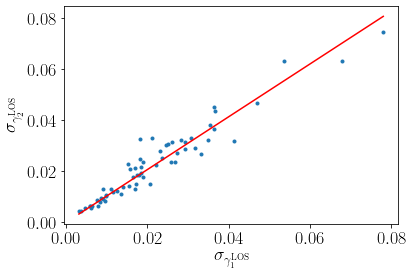

In [94]:
# check that error bars are well correlated
f = lambda x, a: a * x
popt, pcov = curve_fit(f, uncertainty_g1, uncertainty_g2)
print(popt)
mn = np.min(uncertainty_g1)
mx = np.max(uncertainty_g1)
g1 = np.linspace(mn, mx, 2)
g2 = f(g1, *popt)
plt.plot(uncertainty_g1, uncertainty_g2, '.')
plt.plot(g1, g2, '-r')
plt.xlabel(r'$\sigma_{\gamma^{\rm LOS}_1}$')
plt.ylabel(r'$\sigma_{\gamma^{\rm LOS}_2}$')
plt.savefig('correlated_uncertainties.pdf', bbox_inches='tight')
plt.show()

[0.71376465]


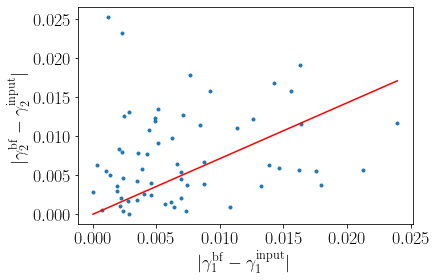

In [95]:
# check that errors are correlated
f = lambda x, a: a * x
popt, pcov = curve_fit(f, error_g1, error_g2)
print(popt)
mn = np.min(error_g1)
mx = np.max(error_g1)
delta1 = np.linspace(mn, mx, 2)
delta2 = f(delta1, *popt)
plt.plot(error_g1, error_g2, '.')
plt.plot(delta1, delta2, '-r')
plt.xlabel(r'$|\gamma_1^{\rm bf}-\gamma_1^{\rm input}|$')
plt.ylabel(r'$|\gamma_2^{\rm bf}-\gamma_2^{\rm input}|$')
plt.savefig('correlated_errors.pdf', bbox_inches='tight')
plt.show()

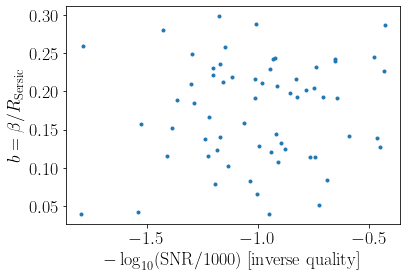

In [96]:
# compare our two measures of quality
plt.plot(-Q, b_g1, '.')
plt.xlabel(r'$-\log_{10}(\mathrm{SNR}/1000)$ [inverse quality]')
plt.ylabel(r'$b=\beta/R_{\rm Sersic}$')
plt.savefig('compare_b_SNR.pdf', bbox_inches='tight')
plt.show()

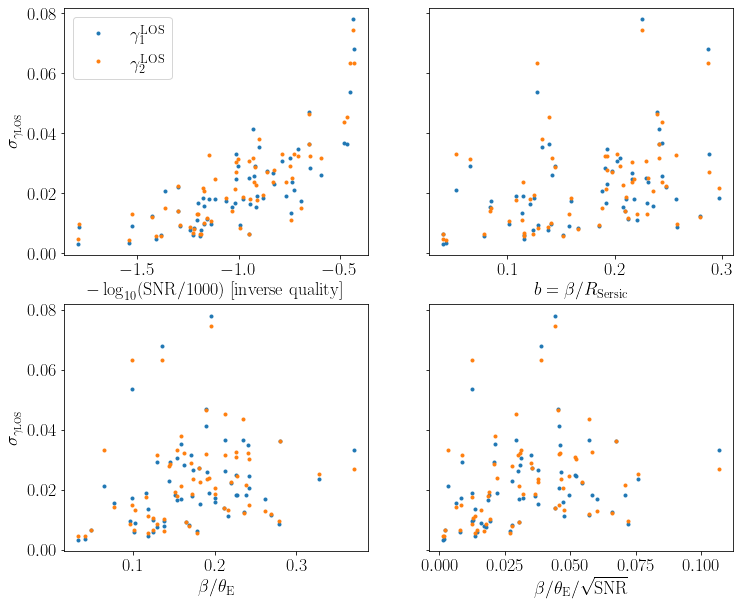

In [97]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12,10))
#fig.subplots_adjust(hspace=0)

axes[0, 0].plot(-Q, uncertainty_g1, '.')
axes[0, 0].plot(-Q, uncertainty_g2, '.')
axes[0, 0].set_ylabel(r'$\sigma_{\gamma_{\rm LOS}}$')
axes[0, 0].set_xlabel(r'$-\log_{10}(\mathrm{SNR}/1000)$ [inverse quality]')
axes[0, 0].legend([r'$\gamma_1^{\rm LOS}$', r'$\gamma_2^{\rm LOS}$'])

axes[0, 1].plot(b_g1, uncertainty_g1, '.')
axes[0, 1].plot(b_g1, uncertainty_g2, '.')
axes[0, 1].set_xlabel(r'$b=\beta/R_{\rm Sersic}$')
#axes[0, 1].legend([r'$\gamma_1^{\rm LOS}$', r'$\gamma_2^{\rm LOS}$'])

axes[1, 0].plot(beta/theta_E, uncertainty_g1, '.')
axes[1, 0].plot(beta/theta_E, uncertainty_g2, '.')
axes[1, 0].set_xlabel(r'$\beta/\theta_{\rm E}$')
axes[1, 0].set_ylabel(r'$\sigma_{\gamma_{\rm LOS}}$')
#axes[1, 0].legend([r'$\gamma_1^{\rm LOS}$', r'$\gamma_2^{\rm LOS}$'])

axes[1, 1].plot(beta/theta_E*b_g1, uncertainty_g1, '.')
axes[1, 1].plot(beta/theta_E*b_g1, uncertainty_g2, '.')
axes[1, 1].set_xlabel(r'$\beta/\theta_{\rm E}/\sqrt{\mathrm{SNR}}$')

#plt.savefig('sigma.pdf', bbox_inches='tight')
plt.show()

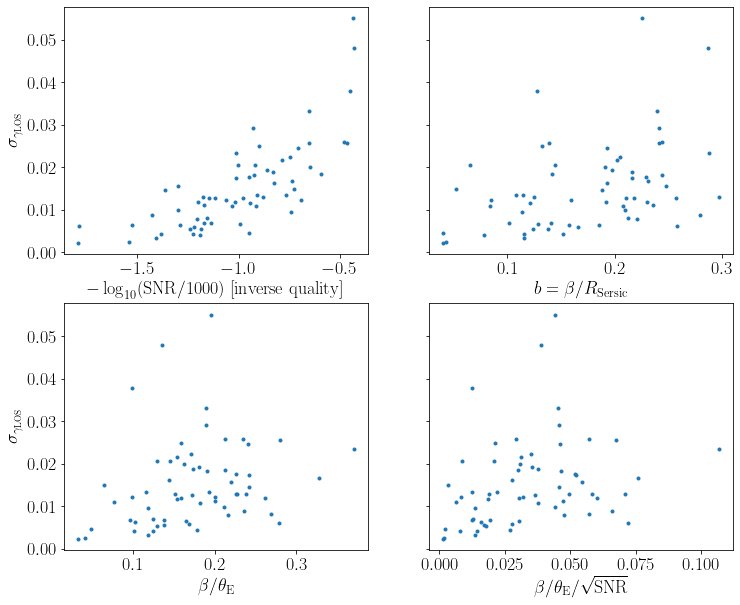

In [98]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12,10))
#fig.subplots_adjust(hspace=0)

axes[0, 0].plot(-Q, sigma, '.')
axes[0, 0].set_ylabel(r'$\sigma_{\gamma_{\rm LOS}}$')
axes[0, 0].set_xlabel(r'$-\log_{10}(\mathrm{SNR}/1000)$ [inverse quality]')

axes[0, 1].plot(b_g1, sigma, '.')
axes[0, 1].set_xlabel(r'$b=\beta/R_{\rm Sersic}$')

axes[1, 0].plot(beta/theta_E, sigma, '.')
axes[1, 0].set_xlabel(r'$\beta/\theta_{\rm E}$')
axes[1, 0].set_ylabel(r'$\sigma_{\gamma_{\rm LOS}}$')

axes[1, 1].plot(beta/theta_E*b_g1, sigma, '.')
axes[1, 1].set_xlabel(r'$\beta/\theta_{\rm E}/\sqrt{\mathrm{SNR}}$')

#plt.savefig('sigma.pdf', bbox_inches='tight')
plt.show()

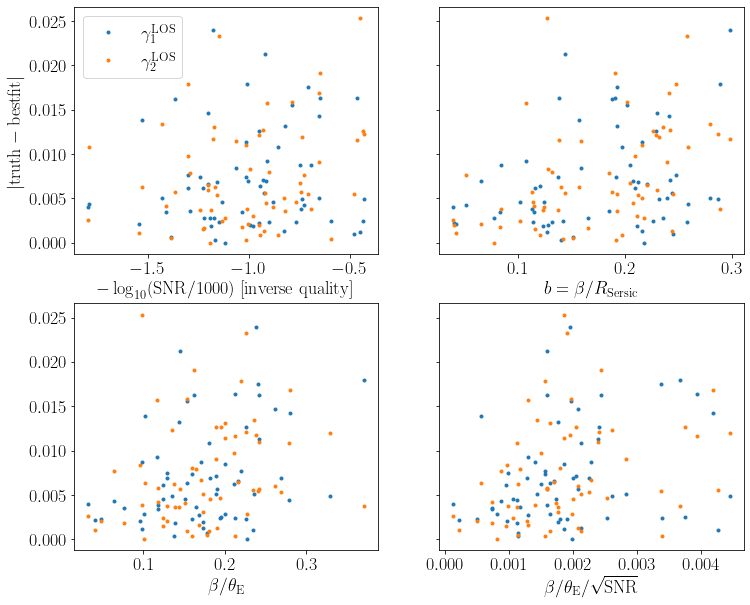

In [99]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12,10))
#fig.subplots_adjust(hspace=0)

axes[0, 0].plot(-Q, error_g1, '.')
axes[0, 0].plot(-Q, error_g2, '.')
axes[0, 0].set_ylabel(r'$|\mathrm{truth}-\mathrm{best fit}|$')
axes[0, 0].set_xlabel(r'$-\log_{10}(\mathrm{SNR}/1000)$ [inverse quality]')
axes[0, 0].legend([r'$\gamma_1^{\rm LOS}$', r'$\gamma_2^{\rm LOS}$'])

axes[0, 1].plot(b_g1, error_g1, '.')
axes[0, 1].plot(b_g1, error_g2, '.')
axes[0, 1].set_xlabel(r'$b=\beta/R_{\rm Sersic}$')
#axes[0, 1].legend([r'$\gamma_1^{\rm LOS}$', r'$\gamma_2^{\rm LOS}$'])

axes[1, 0].plot(beta/theta_E, error_g1, '.')
axes[1, 0].plot(beta/theta_E, error_g2, '.')
axes[1, 0].set_xlabel(r'$\beta/\theta_{\rm E}$')
axes[0, 0].set_ylabel(r'$|\mathrm{truth}-\mathrm{best fit}|$')
#axes[1, 0].legend([r'$\gamma_1^{\rm LOS}$', r'$\gamma_2^{\rm LOS}$'])

axes[1, 1].plot(beta/theta_E/np.sqrt(quality), error_g1, '.')
axes[1, 1].plot(beta/theta_E/np.sqrt(quality), error_g2, '.')
axes[1, 1].set_xlabel(r'$\beta/\theta_{\rm E}/\sqrt{\mathrm{SNR}}$')

plt.savefig('error_SNR_b.pdf', bbox_inches='tight')
plt.show()

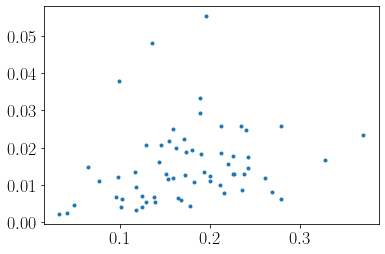

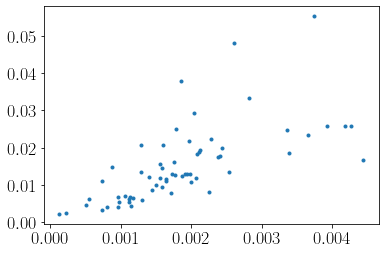

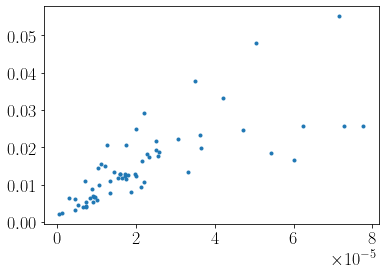

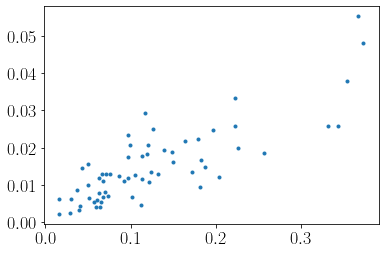

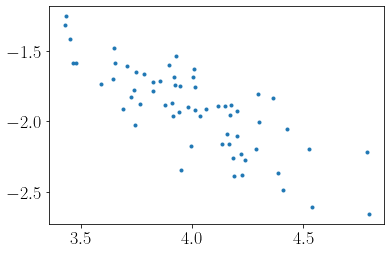

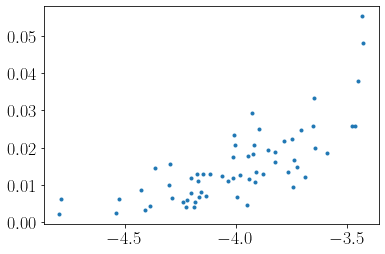

In [100]:
X = beta / theta_E
plt.plot(X, sigma, '.')
plt.show()

X = beta / theta_E / quality**0.5
plt.plot(X, sigma, '.')
plt.show()

X = beta / theta_E / quality
plt.plot(X, sigma, '.')
plt.show()

X = 1000 / quality
plt.plot(X, sigma, '.')
plt.show()

X = np.log10(quality)
Y = np.log10(sigma)
plt.plot(X, Y, '.')
plt.show()

X = - np.log10(quality)
Y = sigma
plt.plot(X, Y, '.')
plt.show()

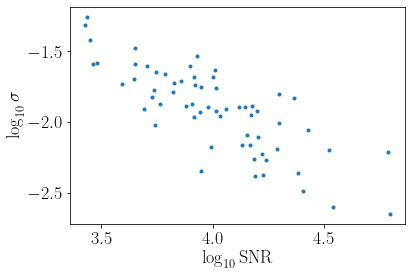

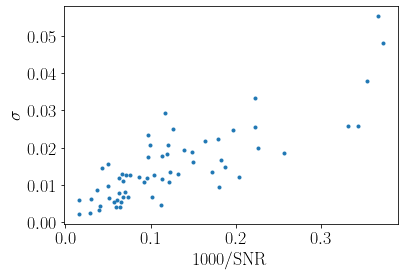

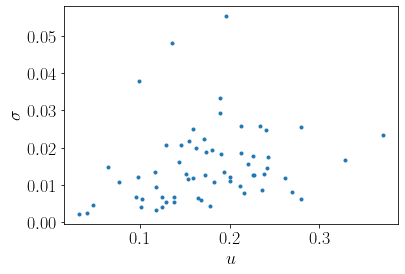

In [104]:
X = np.log10(quality)
Y = np.log10(sigma)
plt.plot(X, Y, '.')
plt.xlabel(r"$\log_{10}\mathrm{SNR}$")
plt.ylabel(r"$\log_{10}\sigma$")
plt.show()

X = 1000 / quality
Y = sigma
plt.plot(X, Y, '.')
plt.xlabel(r"$1000/\mathrm{SNR}$")
plt.ylabel(r"$\sigma$")
plt.show()

X = beta / theta_E
Y = sigma
plt.plot(X, Y, '.')
plt.xlabel(r"$u$")
plt.ylabel(r"$\sigma$")
plt.show()